# Abstract

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Market Value Model 

In [3]:
value_all_players = pd.read_csv("upd_pldata.csv")

In [4]:
value_all_players.columns = value_all_players.columns.str.replace('.', '_')
value_all_players.columns = value_all_players.columns.str.replace('___', '_')
value_all_players.columns = value_all_players.columns.str.replace(' ', '_')

/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_89266/1519655258.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  value_all_players.columns = value_all_players.columns.str.replace('.', '_')


In [5]:
value_all_players.shape

(5700, 59)

## Preliminary Vizualizations

In [6]:
final_value_all_players = pd.DataFrame(value_all_players, columns = ["Name"])
final_value_all_players["actual"] = value_all_players['Value'].copy()

Text(0.5, 1.0, 'Value vs. Years Left')

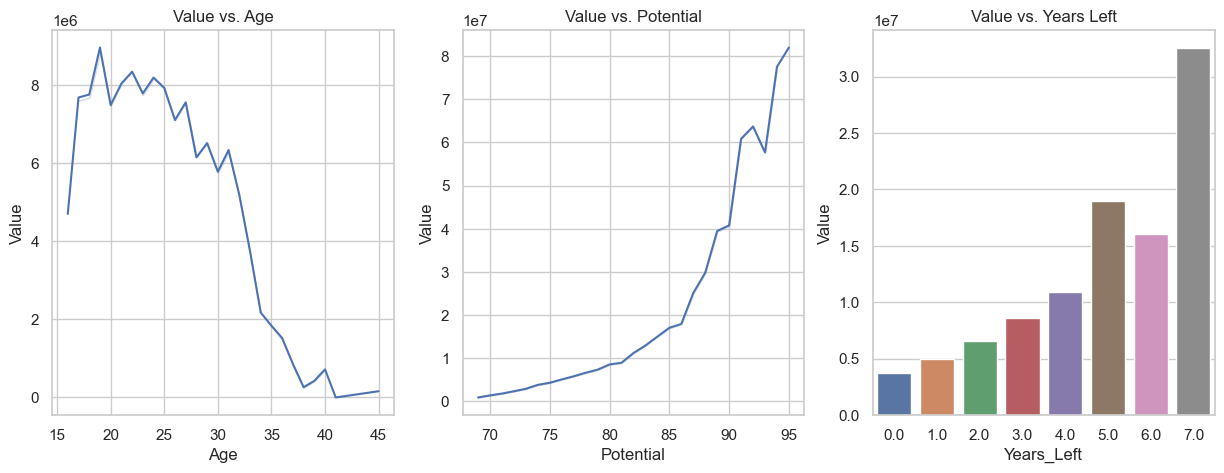

In [424]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False)

sns.lineplot(data=value_all_players, x="Age", y="Value", errorbar=('ci', False), ax = axarr[0]).set_title('Value vs. Age')

sns.lineplot(data=value_all_players, x="Potential", y="Value", errorbar=('ci', False), ax = axarr[1]).set_title('Value vs. Potential')

sns.barplot(data=value_all_players, x=(value_all_players["Years_Left"]), y="Value", errorbar=('ci', False), ax = axarr[2]).set_title('Value vs. Years Left')

## Prepare Data for Modeling

In [444]:
from sklearn.model_selection import train_test_split
value_all_train, value_all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)


value_all_train = value_all_train.drop(["Name"], axis = 1)
value_all_train = value_all_train.drop(["field_position"], axis = 1)

value_all_test = value_all_test.drop(["Name"], axis = 1)
value_all_test = value_all_test.drop(["field_position"], axis = 1)


#standardized and back to df
#Turn off for predictions?
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
value_all_train = pd.DataFrame(sc.fit_transform(value_all_train), columns = value_all_train.columns)

sc = StandardScaler()
value_all_test = pd.DataFrame(sc.fit_transform(value_all_test), columns = value_all_test.columns)

#getting the target vector and deleting it from feature matrix

X_train_value = value_all_train.dropna(how='any', inplace=True)
X_train_value = value_all_train.drop(["Value"], axis = 1)
y_train_value = value_all_train["Value"]



X_test_value = value_all_test.dropna(how='any', inplace=True)
X_test_value = value_all_test.drop(["Value"], axis = 1)
y_test_value = value_all_test["Value"]

## Feature Selection

In [474]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X_train_value, y_train_value)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_value.columns
ordered_mutual_info = mutual_info.sort_values(ascending=False)

<AxesSubplot: >

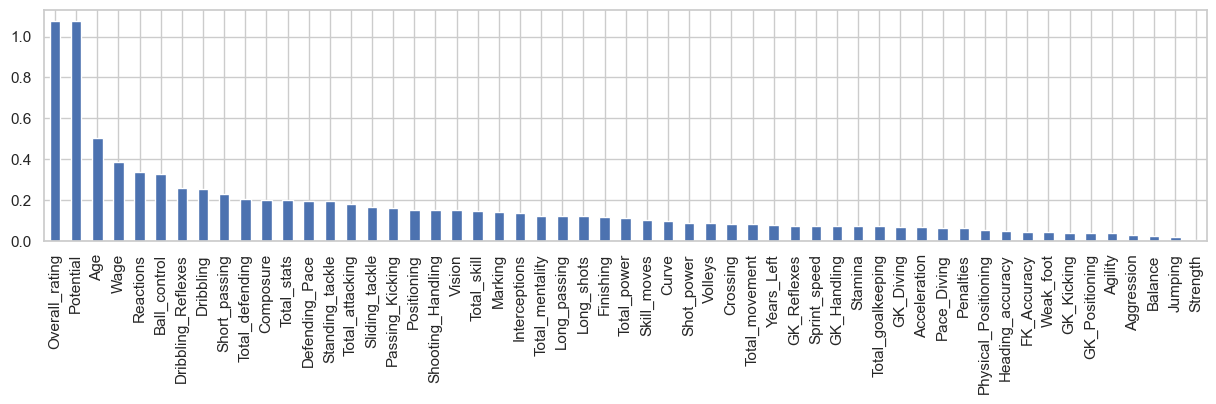

In [477]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,3)) #title it

In [448]:
from sklearn.feature_selection import SelectPercentile #use selectk best
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=30)
selected_top_columns.fit(X_train_value, y_train_value)

SelectPercentile(percentile=30,
                 score_func=<function mutual_info_regression at 0x7fa2a9bd3820>)

In [449]:
X_train_value.columns[selected_top_columns.get_support()] #store in a variable

Index(['Age', 'Overall_rating', 'Potential', 'Total_stats', 'Wage',
       'Total_attacking', 'Short_passing', 'Dribbling', 'Ball_control',
       'Reactions', 'Composure', 'Total_defending', 'Standing_tackle',
       'Sliding_tackle', 'Passing_Kicking', 'Dribbling_Reflexes',
       'Defending_Pace'],
      dtype='object')

In [467]:
#https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regressionD

pearson_corr = r_regression(X_train_value, y_train_value)

In [468]:
pearson_corr = pd.Series(pearson_corr)
pearson_corr.index = X_train_value.columns
#pearson_corr.sort_values(ascending=False)

<AxesSubplot: >

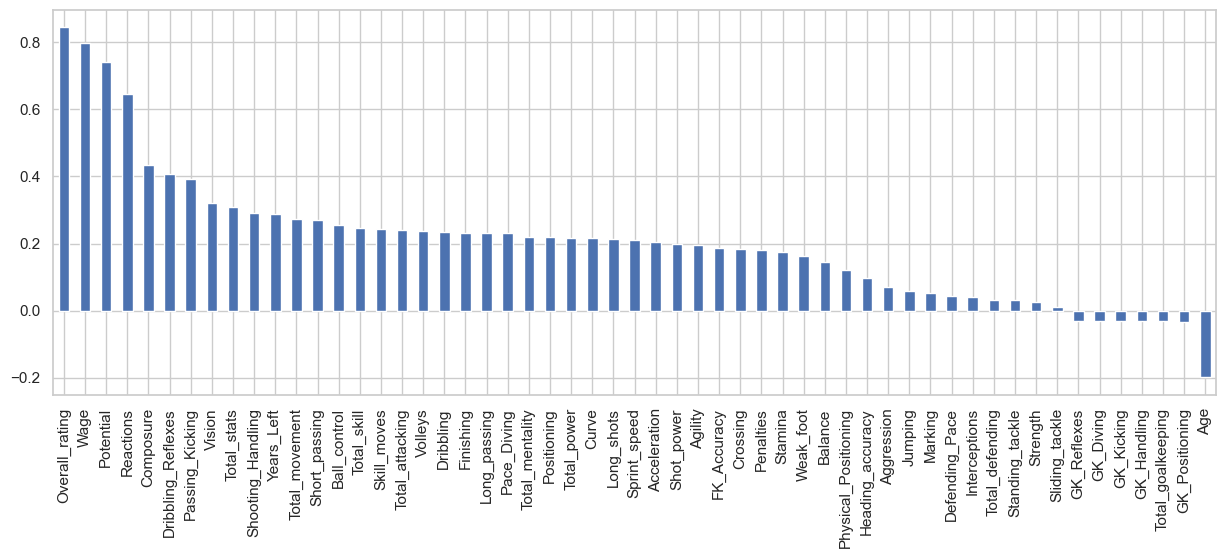

In [469]:
pearson_corr.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [472]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
selected_top_columns = SelectKBest(r_regression, k=30)
selected_top_columns.fit(X_train_value, y_train_value)

X_train_value.columns[selected_top_columns.get_support()]

Index(['Overall_rating', 'Potential', 'Years_Left', 'Total_stats', 'Wage',
       'Total_attacking', 'Finishing', 'Short_passing', 'Volleys',
       'Total_skill', 'Dribbling', 'Curve', 'Long_passing', 'Ball_control',
       'Total_movement', 'Acceleration', 'Sprint_speed', 'Reactions',
       'Total_power', 'Shot_power', 'Long_shots', 'Total_mentality',
       'Positioning', 'Vision', 'Composure', 'Skill_moves', 'Pace_Diving',
       'Shooting_Handling', 'Passing_Kicking', 'Dribbling_Reflexes'],
      dtype='object')

In [471]:
X_train_value_sel = X_train_value[['Overall_rating', 'Potential', 'Years_Left', 'Total_stats', 'Wage',
       'Reactions', 'Vision', 'Composure', 'Passing_Kicking',
       'Dribbling_Reflexes']]


X_test_value_sel = X_test_value[['Overall_rating', 'Potential', 'Years_Left', 'Total_stats', 'Wage',
       'Reactions', 'Vision', 'Composure', 'Passing_Kicking',
       'Dribbling_Reflexes']]

In [86]:
from sklearn.feature_selection import RFECV
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value_sel, y_train_value)


print(selector.n_features_)
#selector.cv_results_
X_train_value_sel_final_index = X_train_value_sel.columns[selector.get_support()]
X_train_value_sel_final = X_train_value_sel[X_train_value_sel_final_index]

7


10


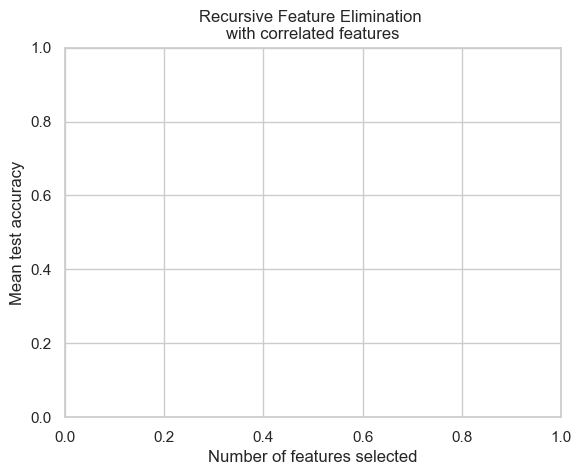

In [473]:
n_scores = len(selector.cv_results_["mean_test_score"])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [83]:
from sklearn.linear_model import LinearRegression
Lol8 = LinearRegression()
Lol8.fit(X_train_value_sel_final, y_train_value)
# Lol8.score(X_test_value_sel, y_test_value)

Lol8.coef_

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(Lol8, X_train_value_sel_final, y_train_value, cv=5)
print(model_scores.mean())

0.821426088988351


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train_value_sel, y_train_value)

In [ ]:
regr.score(X_test_value_sel, y_test_value)

In [36]:
#cross-validation
import time as tm
start = tm.time()

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(regr, X_train_value, y_train_value, cv=5)
print(model_scores.mean())


running_secs = (tm.time() - start)



NameError: name 'regr' is not defined

In [117]:
print(running_secs)

32.58747386932373


In [30]:
#cross-validation
import time as tm
start = tm.time()

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(regr, X_train_value_sel, y_train_value, cv=5)
print(model_scores.mean())

running_secs = (tm.time() - start)

0.957950858889275


In [31]:
print(running_secs)

4.818767070770264


## Model Performance

In [37]:
LinearRegression_pf = []
rfr_pf = []

for i in range(1,10):
    from sklearn.model_selection import train_test_split
    value_all_train, value_all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)

    #final_value_all_players = pd.DataFrame(at_test, columns = ["Name"])
    #final_value_all_players["actual"] = at_test['Value'].copy()


    # #standardized and back to df
    # from sklearn.preprocessing import StandardScaler
    # sc = StandardScaler()
    # value_all_train = pd.DataFrame(sc.fit_transform(value_all_train), columns = value_all_train.columns)

    #getting the target vector and deleting it from feature matrix

    X_train_value = value_all_train.dropna(how='any', inplace=True)
    X_train_value = value_all_train.drop(["Value"], axis = 1)
    y_train_value = value_all_train["Value"]



    X_test_value = value_all_test.dropna(how='any', inplace=True)
    X_test_value = value_all_test.drop(["Value"], axis = 1)
    y_test_value = value_all_test["Value"]

    X_train_value = X_train_value.drop(["field_position"], axis = 1)
    X_train_value = X_train_value.drop(["Name"], axis = 1)




    X_test_value = X_test_value.drop(["field_position"], axis = 1)
    X_test_value = X_test_value.drop(["Name"], axis = 1)
    
    X_train_value_sel = X_train_value[['Age', 'Overall_rating', 'Potential', 'Total_stats', 'Wage',
       'Total_attacking', 'Short_passing', 'Dribbling', 'Ball_control',
       'Reactions', 'Interceptions', 'Composure', 'Total_defending',
       'Standing_tackle', 'Passing_Kicking', 'Dribbling_Reflexes',
       'Defending_Pace']]


    X_test_value_sel = X_test_value[['Age', 'Overall_rating', 'Potential', 'Total_stats', 'Wage',
       'Total_attacking', 'Short_passing', 'Dribbling', 'Ball_control',
       'Reactions', 'Interceptions', 'Composure', 'Total_defending',
       'Standing_tackle', 'Passing_Kicking', 'Dribbling_Reflexes',
       'Defending_Pace']]
    
    
  


    from sklearn.model_selection import cross_val_score
    model_scores = cross_val_score(Lol8, X_train_value_sel, y_train_value, cv=5)
    LinearRegression_pf.append((model_scores.mean()))
    
    regr = RandomForestRegressor(max_depth = 11, random_state=0)
    regr.fit(X_train_value_sel, y_train_value)
    model_scores = cross_val_score(regr, X_test_value_sel, y_test_value, cv=5)
    rfr_pf.append(model_scores.mean())

In [39]:
print(np.mean(LinearRegression_pf))
print(np.mean(rfr_pf))

0.8396572946942099
0.9417425865791054


## Visualizations

/Users/hedavamsolano/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.19947e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


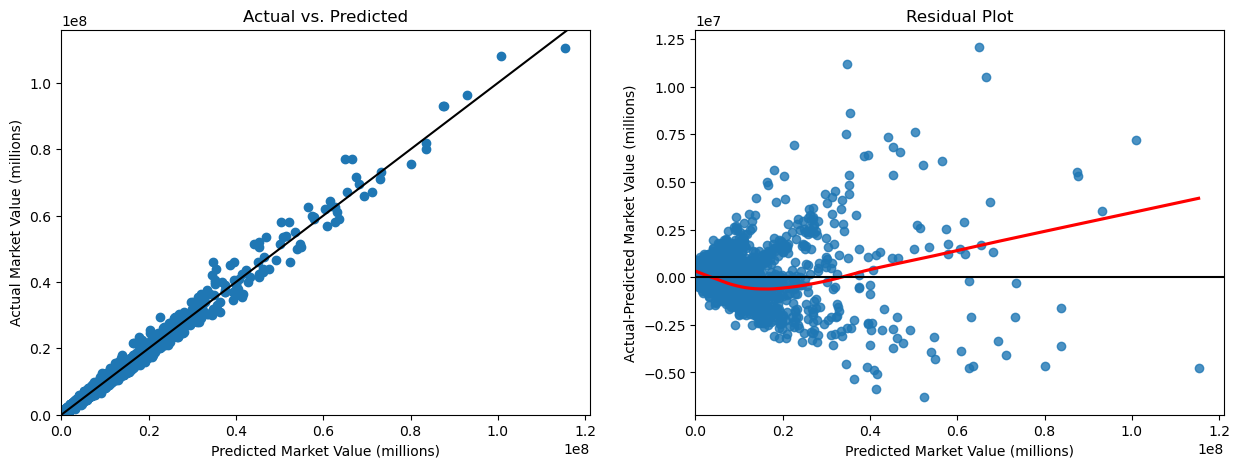

In [137]:
Lol8.fit(X_train_value, y_train_value)
Lol8.predict(X_train_value)
predictions12 = Lol8.predict(X_train_value)
actual = y_train_value


#add this to bias


difference = np.subtract(actual, predictions12)


x_axis_1 = np.linspace(0, len(predictions12), num = len(predictions12))
x_axis_2 = np.linspace(0, len(predictions12), num = len(predictions12))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions12, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions12, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)



labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend


NameError: name 'predictions12' is not defined

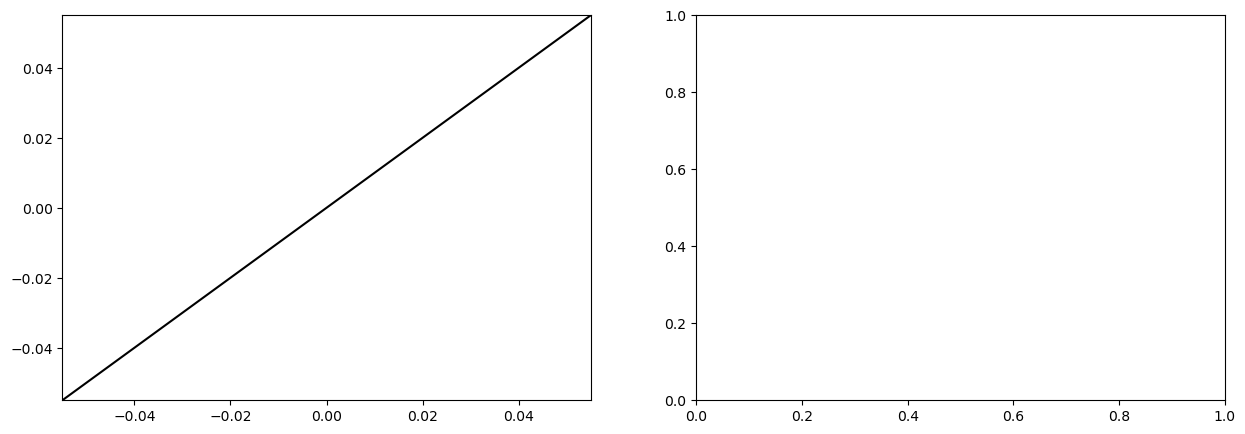

In [196]:
regr.fit(X_train_value, y_train_value)
regr.predict(X_train_value)
predictions123 = regr.predict(X_train_value)
actual = y_train_value


#add this to bias


difference = np.subtract(actual, predictions123)


x_axis_1 = np.linspace(0, len(predictions123), num = len(predictions123))
x_axis_2 = np.linspace(0, len(predictions123), num = len(predictions123))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions12, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions123, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)



labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend


# Take-Away: Big Computational Efficiency Difference with decreased # of features from filter-based feature selection using univariate feature selection!

## Experiments

Notes: time to run might take longer with more features even though accuracy doesn't change; vary the # of samples and see how that affects the learning curves

In [ ]:
#all features time to run vs. feature selection time to run

In [ ]:
X_train_value.iloc[:, 0:3] #get all rows for certain columns; use this in the loop, but no b/cuz we need to go from most important to least important

In [ ]:
((ordered_mutual_info).index[0]) #use this to loop

#X_train_value.iloc[:, 0:ordered_mutual_info.index[0]]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# #effect of overfitting, keeping # features constant and increasing samples (good for when we get new dataset);

# #effect of overfitting, keeping # samples constant and increasing features (good for when we get new dataset);


# #initialize arrays to store scores
# train_score_hist = []
# cv_score_hist = []


# #loop through features:
# for i in range(1, len(ordered_mutual_info)):
#     #fit on training; I don't think I should refit everytime!!!!!
#     L6 = Lasso(alpha = 1) 
#     L6.fit(X_train_value.iloc[:, 0:ordered_mutual_info.index[i]], y_train_value.iloc[0:i])
    
#     #score on training
#     #print(L6.score(X_train_fee.iloc[0:i],y_train_fee.iloc[0:i]))
#     train_score_hist.append(L6.score(X_train_fee.iloc[:, 0:i],y_train_value.iloc[:, 0:i]))  #update model's training score
    
#     #cross-validation
#     cv_score_hist.append(cross_val_score(L6, X_train_fee.iloc[0:i], y_train_fee.iloc[0:i], cv=5).mean())
 

#     #Graph it
#     num_steps = len(train_score_hist)
#     plt.plot(np.arange(num_steps) + 1, cv_score_hist, label = "cross_val")

#     num_steps = len(train_score_hist)
#     plt.plot(np.arange(num_steps) + 1, train_score_hist, label = "train")

#     plt.ylim([0, 1])
#     #change x to be in batches of 5
#     labels = plt.gca().set(title = "Scores vs. Samples", xlabel = "# of Samples (in batches of 5)", ylabel = "Score")


    
# #loop through features:

# #for i in rang

# #effect of overfitting, w/ our # of samples, changing the number of features 

## Model Comparisons + Cross-Validation + Hyperparameter Tuning https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#### Take-Away: Huge discrepancy between holdout method and cross validation method, due to sample size??? double check with larger dataset, and do an experiment

## Experiment: Holdout Set Vs. Cross-Validation Method comparison by Sample Size, # of features

## Feature Importance  https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

# Tranfer Fee Model (updated)

## Import appropriate dataset

In [196]:
tf2_data = pd.read_csv("changed_fifa_transfer fee_final.csv")
tf2_data.shape #dimensions

(708, 78)

In [197]:
#clean column names
tf2_data.columns = tf2_data.columns.str.replace('.', '_')
tf2_data.columns = tf2_data.columns.str.replace('___', '_')
tf2_data.columns = tf2_data.columns.str.replace(' ', '_')

In [198]:
tf2_data.head(3)

,age,fee_cleaned,value_eur,years_left,team,player_name,overall,potential,wage_eur,nationality_name,...,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity
0,27,13.0,7500000.0,1,Barcelona,Jasper Cillessen,79,82,90000.0,Netherlands,...,33.28594,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
1,22,16.5,3800000.0,2,Barcelona,Lucas Digne,76,83,70000.0,France,...,33.28594,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
2,25,1.5,425000.0,3,Eibar,Florian Lejeune,65,70,2000.0,France,...,47.45242,-0.608427,7.804410,7.974349,191,218,54.0253,11.0253,67.72,-487.0


In [199]:
#getting gk datasets
tf2_data_gk_index = tf2_data["position_x"] == "Goalkeeper"
tf2_data_gk = tf2_data[tf2_data_gk_index]

tf2_data_gk_index_2 = tf2_data_gk["fee_cleaned"] > 0
tf2_data_gk = tf2_data_gk[tf2_data_gk_index_2]

tf2_data_gk_index_3 = tf2_data_gk["years_left"] > 0
tf2_data_gk = tf2_data_gk[tf2_data_gk_index_3]

tf2_data_gk = tf2_data_gk.dropna(axis = 1)

In [200]:
tf2_data_gk.shape

(37, 72)

In [201]:
#getting data for field players
tf2_data_field_index = tf2_data["position_x"] != "Goalkeeper"
tf2_data_field = tf2_data[tf2_data_field_index]

tf2_data_field["fee_cleaned"] = tf2_data_field["fee_cleaned"] * 1000000


tf2_data_field_index_2 = tf2_data_field["fee_cleaned"] > 0
tf2_data_field = tf2_data_field[tf2_data_field_index_2]

tf2_data_field_index_3 = tf2_data_field["years_left"] > 0
tf2_data_field = tf2_data_field[tf2_data_field_index_3]

tf2_data_field = tf2_data_field.dropna()

In [202]:
tf2_data_field.shape

(414, 78)

NOTE: Goalkeeper dataset has very few samples, so we decided to omit and model only on field players dataset.

## Preliminary Data Analysis (Visualizations + Tables)

<AxesSubplot: xlabel='value_eur', ylabel='fee_cleaned'>

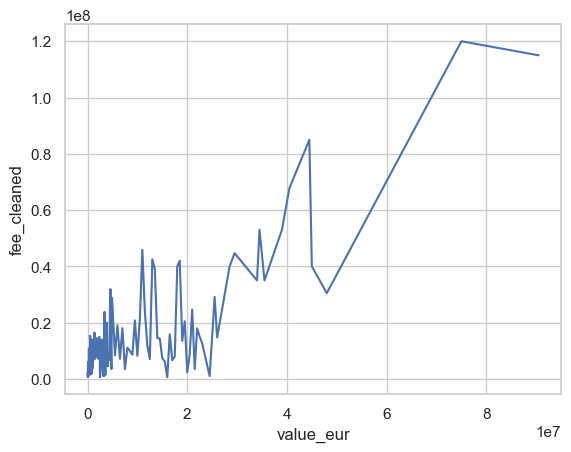

In [203]:
sns.lineplot(data = tf2_data_field, x = "value_eur", y = "fee_cleaned", ci = False)

## Feature Engineering

## Preparing Data For Modeling

In [204]:
from sklearn.model_selection import train_test_split
field_tf_upd_train, field_tf_upd_test = train_test_split(tf2_data_field, test_size = .2, shuffle = True)

#Getting feature matrix

#re-clean; drop categorical, keep numerical

field_tf_upd_train = field_tf_upd_train.drop(["player_name","nationality_name","position_x","league_name_x_y"], axis = 1)
# field_tf_upd_train = field_tf_upd_train.drop(["player_name"], axis = 1)
# field_tf_upd_train = field_tf_upd_train.drop(["nationality_name"], axis = 1)
# field_tf_upd_train = field_tf_upd_train.drop(["position_x"], axis = 1)
# field_tf_upd_train = field_tf_upd_train.drop(["league_name_x_y"], axis = 1)
# field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)

#re-clean; non-numerical stuff
field_tf_upd_test= field_tf_upd_test.drop(["player_name","nationality_name","position_x","league_name_x_y"], axis = 1)
# field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
# field_tf_upd_test = field_tf_upd_test.drop(["player_name"], axis = 1)
# field_tf_upd_test = field_tf_upd_test.drop(["nationality_name"], axis = 1)
# field_tf_upd_test = field_tf_upd_test.drop(["position_x"], axis = 1)
# field_tf_upd_test = field_tf_upd_test.drop(["league_name_x_y"], axis = 1)
# field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


#feature engineering on training data
buyer_avg_tf = field_tf_upd_train.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_upd_train.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_upd_train = pd.merge(field_tf_upd_train, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_upd_train = pd.merge(field_tf_upd_train, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_upd_train = field_tf_upd_train.drop(["team"], axis = 1)
field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)


#feature engineering on testing data (added after improved performance on cross-validated scores was observed)
buyer_avg_tf = field_tf_upd_test.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_upd_test.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_upd_test = pd.merge(field_tf_upd_test, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_upd_test = pd.merge(field_tf_upd_test, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


# #TURN OFF FOR PREDICTIONS
# #standardized and back to df
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# field_tf_upd_train = pd.DataFrame(sc.fit_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)

# sc = StandardScaler()
# field_tf_upd_test = pd.DataFrame(sc.fit_transform(field_tf_upd_test), columns = field_tf_upd_test.columns)


#Choosing target vector
X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
y_train_fee = field_tf_upd_train["fee_cleaned"]

X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
y_test_fee = field_tf_upd_test["fee_cleaned"]

In [205]:
y_train_fee

0       2500000.0
1       4500000.0
2       2000000.0
3       1100000.0
4      30000000.0
          ...    
326     2700000.0
327    16500000.0
328      500000.0
329    22000000.0
330     5500000.0
Name: fee_cleaned, Length: 331, dtype: float64

## Feature selection
# try select from model, and RFE; compare

## Filter Method: Univariate; mutual_info_regression + select_k_best; https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a

In [206]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X_train_fee, y_train_fee)
mutual_info

array([0.0659138 , 0.12955822, 0.00774664, 0.11523793, 0.17394725,
       0.13230098, 0.        , 0.04996271, 0.06442778, 0.        ,
       0.06604865, 0.03405526, 0.00935171, 0.        , 0.01315733,
       0.01101954, 0.026834  , 0.        , 0.04692422, 0.        ,
       0.00109822, 0.00696144, 0.0128074 , 0.00591239, 0.02425864,
       0.05550513, 0.04888057, 0.01572414, 0.0555061 , 0.00900423,
       0.02780198, 0.05501939, 0.        , 0.        , 0.01883197,
       0.        , 0.04908795, 0.01479037, 0.06783164, 0.02520578,
       0.        , 0.        , 0.        , 0.        , 0.0476223 ,
       0.08596757, 0.01078015, 0.06897605, 0.17506905, 0.01869386,
       0.14424583, 0.        , 0.12438161, 0.09000683, 0.11462206,
       0.20485797, 0.1601679 , 0.00869852, 0.16970584, 0.10719027,
       0.        , 0.07423931, 0.10997384, 0.04230903, 0.20544273,
       0.17371591, 0.05584121, 0.111357  , 0.09200998, 0.14573835,
       0.14948888, 0.42884618, 0.65116333])

In [207]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_fee.columns
mutual_info.sort_values(ascending=False)

fee_cleaned_seller_avg         0.651163
fee_cleaned_buyer_avg          0.428846
oppda_coef                     0.205443
pts                            0.204858
position_y                     0.175069
                                 ...   
goalkeeping_diving             0.000000
defending_sliding_tackle       0.000000
defending_standing_tackle      0.000000
defending_marking_awareness    0.000000
attacking_volleys              0.000000
Length: 73, dtype: float64

<AxesSubplot: >

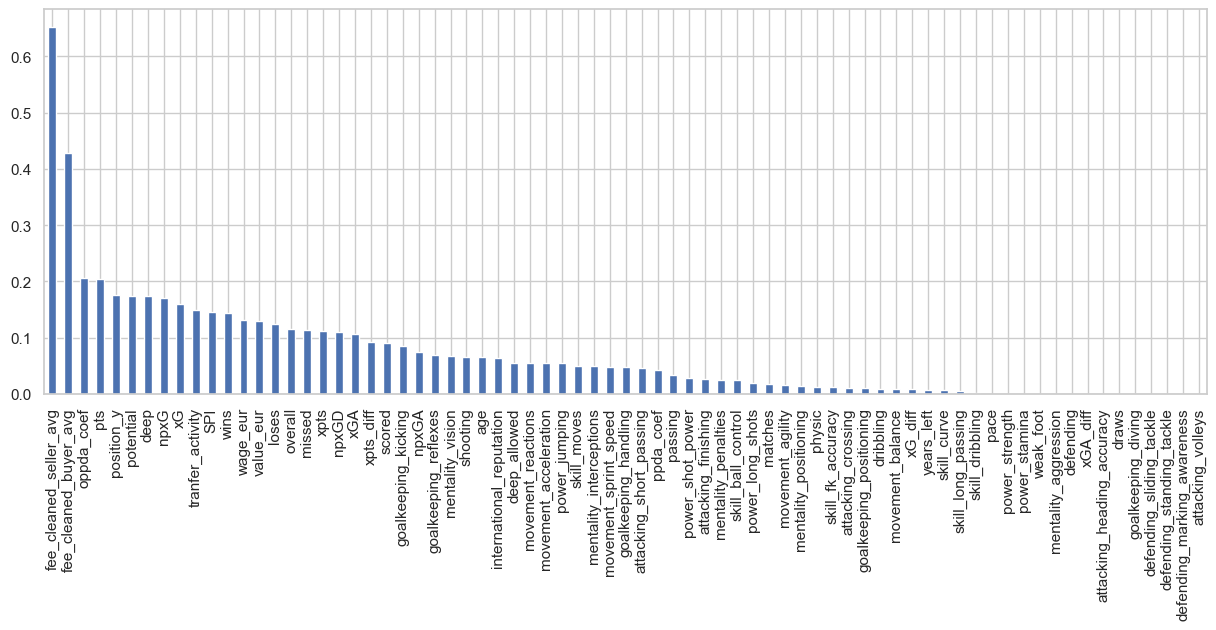

In [208]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [209]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=30)
selected_top_columns.fit(X_train_fee, y_train_fee)
selected_top_columns.get_support()

array([False,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True])

In [210]:
X_train_fee.columns[selected_top_columns.get_support()]

Index(['value_eur', 'overall', 'potential', 'wage_eur', 'position_y', 'wins',
       'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGD',
       'oppda_coef', 'deep', 'xpts', 'xpts_diff', 'SPI', 'tranfer_activity',
       'fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg'],
      dtype='object')

In [211]:
#https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

pearson_corr = r_regression(X_train_fee, y_train_fee)

In [212]:
pearson_corr = pd.Series(pearson_corr)
pearson_corr.index = X_train_fee.columns
pearson_corr.sort_values(ascending=False)

fee_cleaned_buyer_avg     0.811890
fee_cleaned_seller_avg    0.684397
deep                      0.546788
value_eur                 0.534023
npxG                      0.463381
                            ...   
xGA                      -0.236106
missed                   -0.243954
tranfer_activity         -0.351485
loses                    -0.355216
position_y               -0.415004
Length: 73, dtype: float64

<AxesSubplot: >

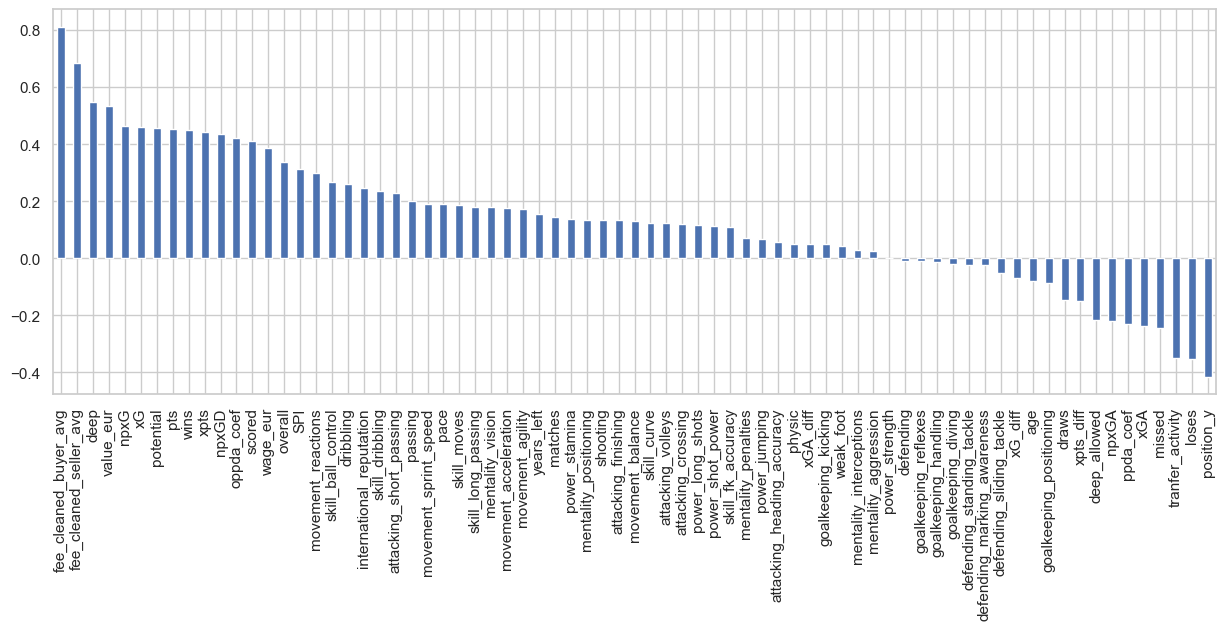

In [213]:
pearson_corr.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [214]:
# X_train_fee = X_train_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
#        'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
#        'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
#        'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
#        'fee_cleaned_seller_avg']]

# X_test_fee = X_test_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
#        'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
#        'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
#        'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
#        'fee_cleaned_seller_avg']]

In [215]:
### Normal LR, performs worse without the filter feature selection; visual?

In [216]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_fee, y_train_fee)
# lr.score(X_test_fee, y_test_fee)

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(lr, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

0.6010281807322032


### RFE

In [217]:
# from sklearn.feature_selection import RFECV
# estimator = LinearRegression()
# selector = RFECV(estimator, step=1, cv=5)
# selector = selector.fit(X_train_fee, y_train_fee)

#selector.n_features_
#selector.cv_results_
#X_train_fee.columns[selector.get_support()]

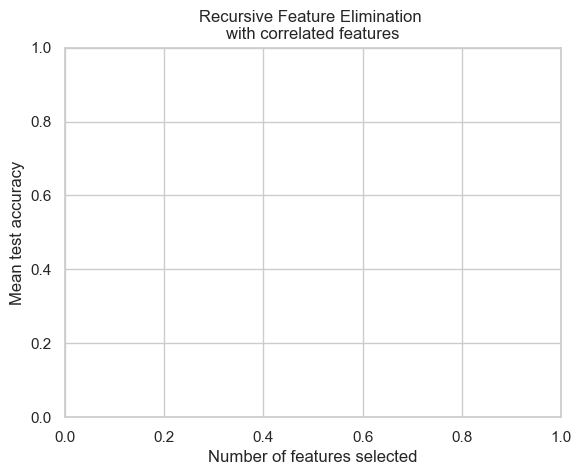

In [218]:
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Embedded Methods NEXT: Deal w/ multi-collinearity and how they compare with perfomance to filter methods.

In [219]:
#LASSO for feature selection, Ridge to deal w/ multi-collinearity

In [220]:
#normalize (standardize) data; important for interpreting linear model's coefficients b/cuz the penalties are dependent on scale


from sklearn.linear_model import Lasso
Lassolr99 = Lasso(alpha = 0.005)
Lassolr99.fit(X_train_fee, y_train_fee)
print(Lassolr99.score(X_train_fee, y_train_fee))
print(Lassolr99.score(X_test_fee, y_test_fee))
model_scores = cross_val_score(Lassolr99, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

lassolr_coefs = Lassolr99.coef_


print(Lassolr99.coef_)





sorted_ascend_params = np.argsort(lassolr_coefs) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))

# toplot = pd.Series(sorted_descend_params)
# toplot.index = X_train_fee.columns[sorted_descend_params[:7]]
# toplot.sort_values(ascending=False).plot.bar(figsize=(15,5))

# # create a list
# my_list = sorted_descend_params

# # create a dataframe with the list as a column
# df = pd.DataFrame({'my_column': my_list})

# # print the dataframe
# print(df)



print("Top 5 features that contribute the MOST to increased transfer fee paid:")
print(X_train_fee.columns[sorted_descend_params[:7]]) #use as column names ; #match 

print(type(sorted_descend_params))


# data = Lassolr99.coef_
# index = [X_train_fee.columns[sorted_descend_params[1]]]
# df = pd.DataFrame(data=data, columns=index)
# print(df)


#least important ones
print("Top 5 features that contribute the LEAST to increased transfer fee paid:")
print(X_train_fee.columns[sorted_descend_params[-7:]])

# #Select from model if we were passing it into lr again




# #try ridge after filtering. could be useful here
# from sklearn.linear_model import Ridge
# Ridgelr99 = Ridge(alpha = 0.0015)
# Ridgelr99.fit(X_train_fee, y_train_fee)
# print(Ridgelr99.score(X_test_fee, y_test_fee))
# model_scores = cross_val_score(Ridgelr99, X_train_fee, y_train_fee, cv=10)
# print(model_scores.mean())

# Ridgelr_coefs = Ridgelr99.coef_

# print(Ridgelr99.coef_)


# sorted_ascend_params = np.argsort(Ridgelr_coefs) #Returns the indices that would sort an array in ascending order
# sorted_descend_params = list(reversed(sorted_ascend_params))

# print("Top 5 features that contribute the most to increased ridership as determined by our model:")
# print(X_train_fee.columns[sorted_descend_params[:7]])


#Visualize this bs

0.801168635434634
0.8968563763156744
0.6090778163761471
[-5.39613792e+05  5.84868540e-01  1.77819598e+06  2.26853339e+05
 -1.64724931e+05 -6.54643663e+01  1.53443233e+05 -1.09015576e+06
 -2.49422240e+06  3.85854601e+05  2.65125417e+05  6.54577780e+05
 -2.98770098e+05 -9.52715985e+04 -6.25294086e+05 -1.05578294e+05
 -1.95655726e+05  8.21995703e+04 -3.08928410e+05 -1.02173500e+05
  3.71009860e+05 -1.62577666e+05  7.26098648e+04 -1.60478052e+04
  9.54383727e+04 -7.35288952e+04 -3.84508505e+05  5.00208323e+04
  1.72347865e+05  1.95508792e+04  2.12033001e+04  6.45161899e+04
  1.50708665e+05  3.19570069e+05 -5.69248060e+04  1.08818506e+05
 -5.87264450e+03 -1.40071634e+05 -1.98648018e+05  8.90849085e+03
 -1.03087379e+05  6.94971653e+04 -6.51545576e+04  1.20064748e+05
 -9.27156421e+04  3.59808148e+05  1.27730719e+05 -1.71571928e+05
  2.43137545e+05 -5.84905760e+05  2.97623362e+05 -1.77377673e+04
 -7.23201575e+04 -2.84529045e+05  1.62134387e+05  3.23244891e+05
 -3.47978840e+05 -1.95189085e+05  

In [221]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth = 11, random_state=0)
regr.fit(X_train_fee, y_train_fee)
model_scores = cross_val_score(regr, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

# Get numerical feature importances
importances = list(regr.feature_importances_)

sorted_ascend_params = np.argsort(importances) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))

print("Top 5 features that contribute the most to increased ridership as determined by our model:")
print(X_train_fee.columns[sorted_descend_params[:7]])

predictions = regr.predict(X_train_fee)


0.6572684816931158
Top 5 features that contribute the most to increased ridership as determined by our model:
Index(['fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg', 'potential',
       'movement_agility', 'xpts_diff', 'dribbling', 'age'],
      dtype='object')


In [222]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(regr.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [223]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 20, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#funciton to measure quality of split
criterion = ["squared_error", "absolute_error", "friedman_mse", "poisson"]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_fee, y_train_fee)


pprint(random_grid)

SyntaxError: invalid character '“' (U+201C) (293360666.py, line 19)

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.model_selection import cross_val_score

#
model_scores = cross_val_score(rf_random.best_estimator_, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

#Base
model_scores = cross_val_score(rf, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
     'n_estimators': [800,1000,1200],
     'min_samples_split': [3,4,5],
     'min_samples_leaf': [0,1,2],
     'max_features': ['auto'],
     'max_depth': [15,20,25],
     'bootstrap': [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_fee, y_train_fee)
grid_search.best_params_

In [ ]:
#
model_scores = cross_val_score(grid_search.best_estimator_, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

#Base
model_scores = cross_val_score(rf, X_train_fee, y_train_fee, cv=5)
print(model_scores.mean())

In [154]:
from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(regr, X_train_fee, y_train_fee, cv=10)
print(model_scores.mean())

0.6947778179482226


#### Hyperparameter Tuning for ElasticNet

In [118]:
# from sklearn.linear_model import ElasticNet
# from sklearn.datasets import make_regression

# reg_lin = ElasticNet(alpha = 0.02, l1_ratio = 1)
# reg_lin.fit(X_train_fee, y_train_fee)
# model_scores = cross_val_score(reg_lin, X_train_fee, y_train_fee, cv=20)
# print(model_scores.mean())

In [119]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV


#Constant that multiplies the penalty terms
alpha = [float(x) for x in np.linspace(start = 0.01, stop = 0.1, num = 10)] #determined with rough tuning done manually

#Mixing parameter determining which penalty to use l1 = 1 will give l1 (lasso) penalty; l1 = 0 will give l2 (ridge) penalty
l1_ratio = [float(x) for x in np.linspace(start = 0, stop = 1, num = 10)] 

# Create the random grid
param_grid = {'alpha': alpha,
               'l1_ratio': l1_ratio}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
base_el = ElasticNet()
# Exhaustive search of parameters, using 3 fold cross validation, 
el_grid = GridSearchCV(estimator = base_el, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search model
el_grid.fit(X_train_fee, y_train_fee)



NameError: name 'ElasticNet' is not defined

In [120]:
el_random.best_params_

NameError: name 'el_random' is not defined

In [121]:
reg_lin = ElasticNet(alpha = 0.04, l1_ratio = 1)
reg_lin.fit(X_train_fee, y_train_fee)
model_scores = cross_val_score(reg_lin, X_train_fee, y_train_fee, cv=20)
print(model_scores.mean())

NameError: name 'ElasticNet' is not defined

## Accuracy Measures

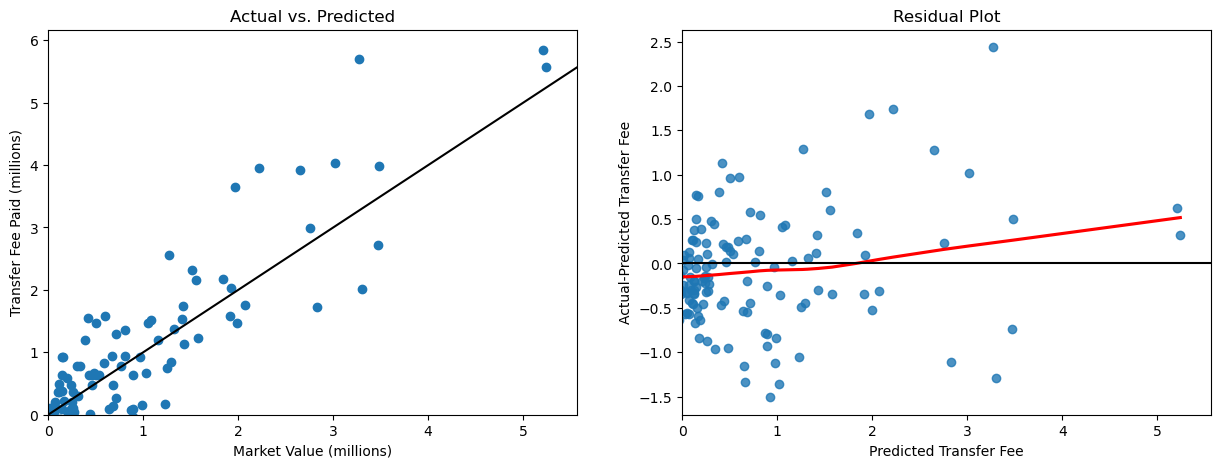

In [122]:
predictions1 = lr.predict(X_train_fee)
actual = y_train_fee


#add this to bias


difference = np.subtract(actual, predictions1)


x_axis_1 = np.linspace(0, len(predictions1), num = len(predictions1))
x_axis_2 = np.linspace(0, len(predictions1), num = len(predictions1))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions1, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions1, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)



labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Market Value (millions)", ylabel = "Transfer Fee Paid (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee", ylabel = "Actual-Predicted Transfer Fee") #add legend


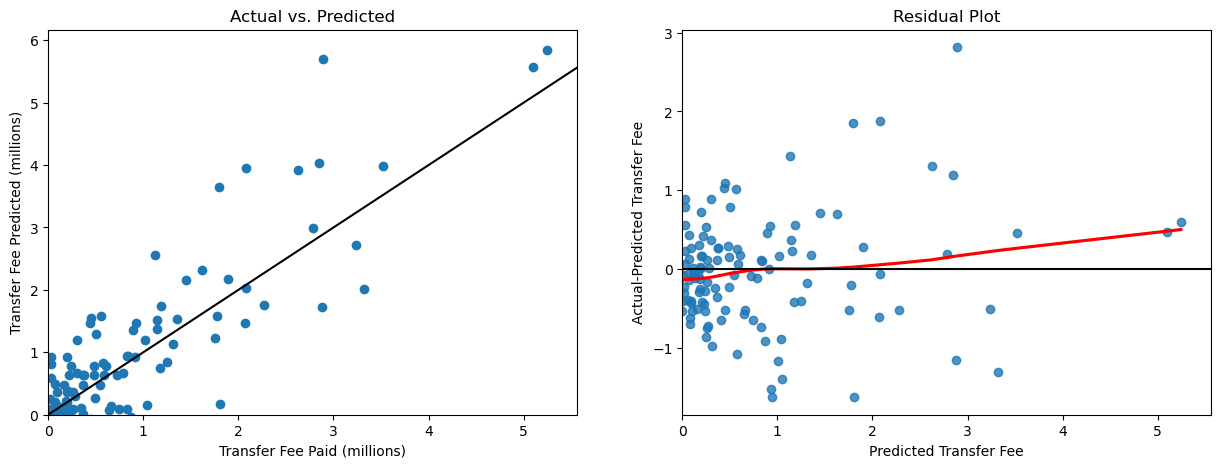

In [123]:
predictions2 = Lassolr99.predict(X_train_fee)
actual = y_train_fee


#add this to bias


difference = np.subtract(actual, predictions2)


x_axis_1 = np.linspace(0, len(predictions2), num = len(predictions2))
x_axis_2 = np.linspace(0, len(predictions2), num = len(predictions2))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions2, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions2, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)


labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Transfer Fee Paid (millions)", ylabel = "Transfer Fee Predicted (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee", ylabel = "Actual-Predicted Transfer Fee") #add legend


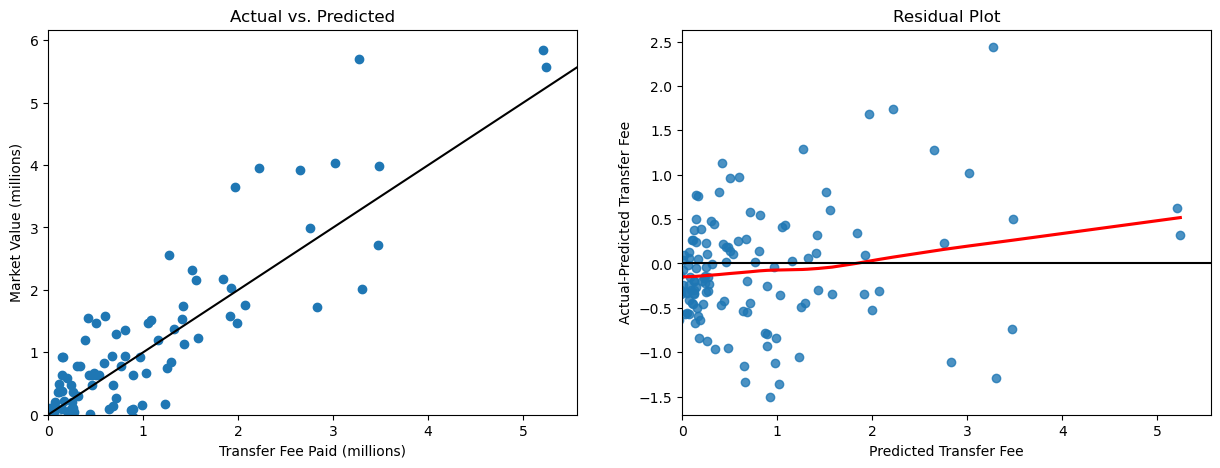

In [124]:
predictions3 = lr.predict(X_train_fee)
actual = y_train_fee


#add this to bias


difference = np.subtract(actual, predictions3)


x_axis_1 = np.linspace(0, len(predictions3), num = len(predictions3))
x_axis_2 = np.linspace(0, len(predictions3), num = len(predictions3))

#length of predictions and actual are the same
x_axis_3 = np.linspace(0, actual.shape[0], actual.shape[0])



fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#plot actual vs. prediction + paramater line
axarr[0].axline((0, 0), slope=1, color = "black")
axarr[0].scatter(x = predictions3, y = actual)
axarr[0].axis(xmin=0,ymin=0)





#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions3, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)



labs = axarr[0].set(title = "Actual vs. Predicted", xlabel = "Transfer Fee Paid (millions)", ylabel = "Market Value (millions)")
labs = axarr[1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee", ylabel = "Actual-Predicted Transfer Fee") #add legend


## Model Comparisons + Cross-Validation + Hyperparameter Tuning https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Performance

In [138]:
lr_pf = []
Lasso_pf = []
rfr_pf = []

X_train_fee_sel = X_train_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
       'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
       'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
       'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
       'fee_cleaned_seller_avg']]

X_test_fee_sel = X_test_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
       'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
       'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
       'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
       'fee_cleaned_seller_avg']]

for i in range(1,10):
    from sklearn.model_selection import train_test_split
    field_tf_upd_train, field_tf_upd_test = train_test_split(tf2_data_field, test_size = .2, shuffle = True)

    #getting the feature matrix and target vector
    # field_tf_upd_train = field_tf_upd_train[field_tf_upd_train.columns[0:8]] #use this!!!
    # field_tf_upd_test = field_tf_upd_test[field_tf_upd_test.columns[0:8]] #use this!!!



    #re-clean; non-numerical stuff
    field_tf_upd_train = field_tf_upd_train.drop(["team"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["player_name"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["nationality_name"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["position_x"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["league_name_x_y"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)

    #re-clean; non-numerical stuff
    field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["player_name"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["nationality_name"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["position_x"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["league_name_x_y"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


    #TURN OFF FOR PREDICTIONS
    #standardized and back to df
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    field_tf_upd_train = pd.DataFrame(sc.fit_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)


    sc = StandardScaler()
    field_tf_upd_test = pd.DataFrame(sc.fit_transform(field_tf_upd_test), columns = field_tf_upd_test.columns)


    X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
    y_train_fee = field_tf_upd_train["fee_cleaned"]

    X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
    y_test_fee = field_tf_upd_test["fee_cleaned"] # do this to get it by index; want to reset the index


    
    
    lr.fit(X_train_fee_sel, y_train_fee)
    lr.score(X_test_fee_sel, y_test_fee)

    from sklearn.model_selection import cross_val_score
    model_scores = cross_val_score(lr, X_train_fee_sel, y_train_fee, cv=5)
    lr_pf.append((model_scores.mean()))
    
    Lassolr99 = Lasso(alpha = 0.005)
    Lassolr99.fit(X_train_fee, y_train_fee)
    model_scores = cross_val_score(Lassolr99, X_train_fee, y_train_fee, cv=5)
    Lasso_pf.append(model_scores.mean())
    
    regr = RandomForestRegressor(max_depth = 11, random_state=0)
    regr.fit(X_train_fee, y_train_fee)
    model_scores = cross_val_score(regr, X_train_fee, y_train_fee, cv=5)
    rfr_pf.append(model_scores.mean())




In [139]:
print(np.mean(lr_pf))
print(np.mean(Lasso_pf))
print(np.mean(rfr_pf))

-0.1268773090295002
0.63520543291876
0.642731242587884


## Learning Curves (by models)

In [395]:
X_train_fee.iloc[0:3]

,AVGage,Foreigners,Pos,GP,W,D,L,GD,Points,Age,...,Base_stats,Weak_foot,Skill_moves,Pace_Diving,Shooting_Handling,Passing_Kicking,Dribbling_Reflexes,Defending_Pace,Physical_Positioning,Years_Left
48,26.4,26,9,38,15,7,16,3,52,24,...,423,4,4,71,70,77,78,61,66,2.0
87,24.4,22,5,38,19,11,8,19,68,20,...,415,3,3,71,70,72,74,64,64,2.0
175,25.4,20,4,38,23,2,13,28,71,20,...,436,2,4,89,75,74,85,40,73,4.0


In [375]:
import warnings
warnings.filterwarnings('ignore')

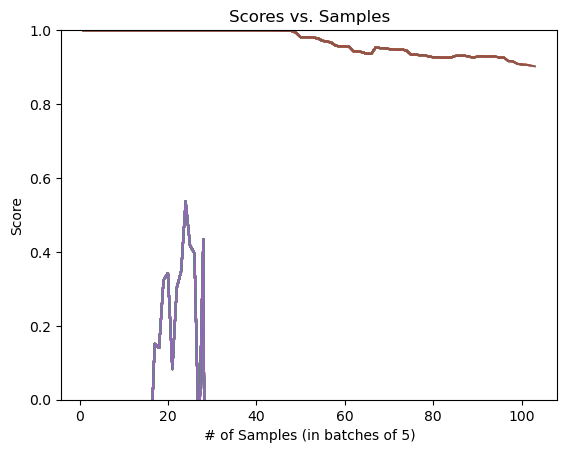

In [399]:
#effect of overfitting, keeping # features constant and increasing samples (good for when we get new dataset);

#effect of overfitting, keeping # samples constant and increasing features (good for when we get new dataset);


#initialize arrays to store scores
train_score_hist = []
cv_score_hist = []


#loop through samples:
for i in range(5, len(X_train_fee)):
    #fit on training; I don't think I should refit everytime!!!!!
    L6 = Lasso(alpha = 1) 
    L6.fit(X_train_fee.iloc[0:i], y_train_fee.iloc[0:i])
    
    #score on training
    #print(L6.score(X_train_fee.iloc[0:i],y_train_fee.iloc[0:i]))
    train_score_hist.append(L6.score(X_train_fee.iloc[0:i],y_train_fee.iloc[0:i]))  #update model's training score
    
    #cross-validation
    cv_score_hist.append(cross_val_score(L6, X_train_fee.iloc[0:i], y_train_fee.iloc[0:i], cv=5).mean())
 

    #Graph it
    num_steps = len(train_score_hist)
    plt.plot(np.arange(num_steps) + 1, cv_score_hist, label = "cross_val")

    num_steps = len(train_score_hist)
    plt.plot(np.arange(num_steps) + 1, train_score_hist, label = "train")

    plt.ylim([0, 1])
    #change x to be in batches of 5
    labels = plt.gca().set(title = "Scores vs. Samples", xlabel = "# of Samples (in batches of 5)", ylabel = "Score")


    
#loop through features:

#for i in rang

#effect of overfitting, w/ our # of samples, changing the number of features 

## Bias Audit: Nationality

In [361]:
#new dataset with only these 5 coountries
#avg. tf for all these countries

#use England, Italy, Germany, France (European soccer powerhouses)

bias_tf_ds = tf2_data_field[tf2_data_field['nationality_name'].isin(['England', "Italy", "Germany","France"])]


bias_tf_ds.nationality_name.value_counts()

France     87
Italy      64
Germany    58
England    32
Name: nationality_name, dtype: int64

In [225]:
bias_tf_ds.head(3)

,age,fee_cleaned,value_eur,years_left,team,player_name,overall,potential,wage_eur,nationality_name,...,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity
1,22,16500000.0,3800000.0,2,Barcelona,Lucas Digne,76,83,70000.0,France,...,33.285940,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
2,25,1500000.0,425000.0,3,Eibar,Florian Lejeune,65,70,2000.0,France,...,47.452420,-0.608427,7.804410,7.974349,191,218,54.0253,11.0253,67.72,-487.0
6,25,9500000.0,5500000.0,1,Sevilla,Wissam Ben Yedder,77,81,50000.0,France,...,43.858446,13.909384,8.600500,8.957718,296,216,63.6363,11.6363,67.72,-487.0


In [226]:
bias_tf_ds_base = bias_tf_ds.groupby("nationality_name", as_index=False)["fee_cleaned"].mean()

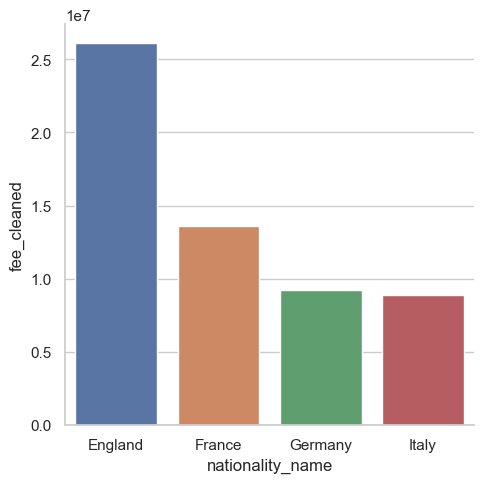

In [227]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_tf_ds_base, kind = "bar", x = "nationality_name", y = "fee_cleaned", legend_out = False, ci = False)

In [228]:
bias_tf_ds.groupby("nationality_name")["fee_cleaned"].mean()

nationality_name
England    2.610156e+07
France     1.362586e+07
Germany    9.245431e+06
Italy      8.867656e+06
Name: fee_cleaned, dtype: float64

In [229]:
# field_tf_upd_test = pd.DataFrame(sc.inverse_transform(field_tf_upd_test), columns = field_tf_upd_test.columns) #reverse standardization
# X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
# y_test_fee = field_tf_upd_test["fee_cleaned"] # do this to get it by index; want to reset the index


# field_tf_upd_train = pd.DataFrame(sc.inverse_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)
# X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
# y_train_fee = field_tf_upd_train["fee_cleaned"] # do this to get it by index; want to reset the index



# bias_tf_ds = field_tf_upd_test.copy()
# bias_tf_ds.rename(columns={'fee_cleaned_threshold':'Actual'}, inplace=True) #rename ValueThreshold to Actual

# #refit on non-standardized
# #re-predict on non-standardized
# regr.fit(X_train_fee, y_train_fee)
# bias_tf_ds["Predicted"] = regr.predict(X_test_fee)

# How Far off Predictions are by nation

# How High are the Predictions by nation

# SEPARATOR

In [230]:
from sklearn.model_selection import train_test_split
field_tf_bias_train, field_tf_bias_test = train_test_split(bias_tf_ds, test_size = .2, shuffle = True)

In [231]:
#Feature matrix 
#field_tf_bias_train = field_tf_bias_train.drop(["team"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["player_name"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["position_x"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["league_name_x_y"], axis = 1)
#field_tf_bias_train = field_tf_bias_train.drop(["club_involved_name"], axis = 1)
#field_tf_bias_train = field_tf_bias_train.drop(["fee_cleaned"], axis = 1)


#field_tf_bias_test = field_tf_bias_test.drop(["team"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["player_name"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["position_x"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["league_name_x_y"], axis = 1)
#field_tf_bias_test = field_tf_bias_test.drop(["club_involved_name"], axis = 1)
#field_tf_bias_test = field_tf_bias_test.drop(["fee_cleaned"], axis = 1)

#feature engineering on training data
buyer_avg_tf = field_tf_bias_train.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_bias_train.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_bias_train = pd.merge(field_tf_bias_train, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_bias_train = pd.merge(field_tf_bias_train, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_bias_train = field_tf_bias_train.drop(["team"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["club_involved_name"], axis = 1)


#feature engineering on testing data (added after improved performance on cross-validated scores was observed)
buyer_avg_tf = field_tf_bias_test.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_bias_test.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_bias_test = pd.merge(field_tf_bias_test, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_bias_test = pd.merge(field_tf_bias_test, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_bias_test = field_tf_bias_test.drop(["team"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["club_involved_name"], axis = 1)



#Getting feature matrix and target vector for train, test
X_tf_bias_train = field_tf_bias_train.drop(["fee_cleaned"], axis = 1)
X_tf_bias_train = X_tf_bias_train.drop(["nationality_name"], axis = 1)
y_tf_bias_train = field_tf_bias_train["fee_cleaned"]

X_tf_bias_test = field_tf_bias_test.drop(["fee_cleaned"], axis = 1)
X_tf_bias_test = X_tf_bias_test.drop(["nationality_name"], axis = 1)
y_tf_bias_test = field_tf_bias_test["fee_cleaned"]

In [398]:
X_tf_bias_train.head(1)

,age,value_eur,years_left,overall,potential,wage_eur,weak_foot,skill_moves,international_reputation,pace,...,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity,fee_cleaned_buyer_avg,fee_cleaned_seller_avg
0,28,21000000.00,2,81,82,40000.00,3,3,2,79.00,...,7.60,8.57,219,215,49.84,-13.16,62.98,-804.00,8076000.00,9550000.00


In [239]:
#use regression model
# from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(max_depth = 40, random_state=0)
# regr.fit(X_tf_bias_train, y_tf_bias_train)
model_scores = cross_val_score(regr, X_tf_bias_train, y_tf_bias_train, cv = 10)
print(model_scores.mean())

0.6384040062544442


In [257]:
bias_ds2 = field_tf_bias_train.copy()
bias_ds2.rename(columns={'fee_cleaned':'Actual'}, inplace=True)
bias_ds2["Predicted"] = regr.predict(X_tf_bias_train)

In [258]:
bias_ds2

,age,Actual,value_eur,years_left,overall,potential,wage_eur,nationality_name,weak_foot,skill_moves,...,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity,fee_cleaned_buyer_avg,fee_cleaned_seller_avg,Predicted
0,28,12000000.00,21000000.00,2,81,82,40000.00,Italy,3,3,...,8.57,219,215,49.84,-13.16,62.98,-804.00,8076000.00,9550000.00,11012970.81
1,27,22000000.00,20500000.00,3,81,87,60000.00,France,3,3,...,10.88,203,215,55.78,6.78,71.92,-5449.00,16028571.43,10333333.33,17884366.20
2,25,5000000.00,3900000.00,1,74,80,20000.00,France,3,2,...,10.21,139,237,34.80,1.80,68.62,-41.00,6166666.67,5000000.00,5111712.08
3,25,3200000.00,950000.00,1,67,70,15000.00,Germany,3,3,...,9.42,150,168,51.69,-11.31,68.62,-41.00,5625000.00,2100000.00,2931304.98
4,22,1500000.00,1400000.00,1,69,78,10000.00,France,2,2,...,9.45,122,213,45.49,8.49,61.30,360.60,1750000.00,3300000.00,1915604.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,23,24000000.00,450000.00,2,63,72,4000.00,Italy,2,2,...,12.07,244,222,58.88,-4.12,62.98,-804.00,16807000.00,12500000.00,19353767.10
188,22,5750000.00,3700000.00,2,71,83,10000.00,Italy,4,3,...,8.94,202,304,41.83,-7.17,62.98,-804.00,3243333.33,10375000.00,5686331.00
189,24,5000000.00,4500000.00,2,72,82,20000.00,France,3,3,...,12.22,233,178,53.00,-7.00,62.98,-804.00,16807000.00,17375000.00,15531369.90
190,28,8000000.00,17500000.00,2,80,81,40000.00,Italy,4,3,...,9.09,200,238,48.95,4.95,62.98,-804.00,5900000.00,4500000.00,4912610.46


In [259]:
bias_ds2_preds = bias_ds2.groupby(["nationality_name"], as_index=False)["Predicted"].mean()

In [260]:
bias_ds2_preds

,nationality_name,Predicted
0,England,19160904.10
1,France,14801928.89
2,Germany,9664065.13
3,Italy,9654791.76


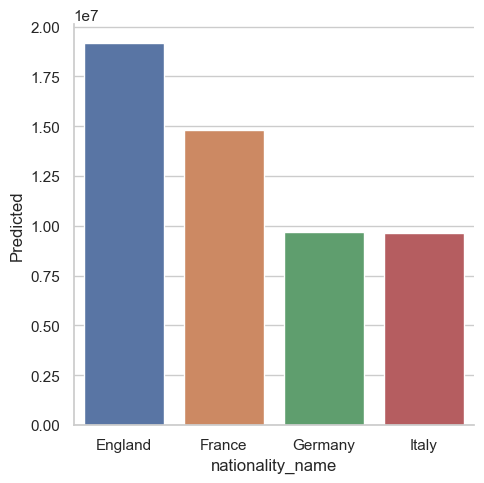

In [245]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds2_preds, kind = "bar", x = "nationality_name", y = "Predicted", legend_out = False)

In [345]:
names = bias_ds2_preds["nationality_name"].drop_duplicates()
names = names.reset_index(drop=True)
names

0    England
1     France
2    Germany
3      Italy
Name: nationality_name, dtype: object

In [367]:
bias_ds2_act_pred = bias_ds2.groupby(["nationality_name"], as_index=False)["Actual","Predicted"].mean()

bias_ds2_residuals = pd.DataFrame(bias_ds2_act_pred.loc[:, 'Actual'] - bias_ds2_act_pred.loc[:, 'Predicted'], columns = ["Differences"])
bias_ds2_residuals["nationality_names"] = names


In [368]:
bias_ds2_residuals

,Differences,nationality_names
0,3539095.90,England
1,-134595.55,France
2,-505111.64,Germany
3,-1262.35,Italy


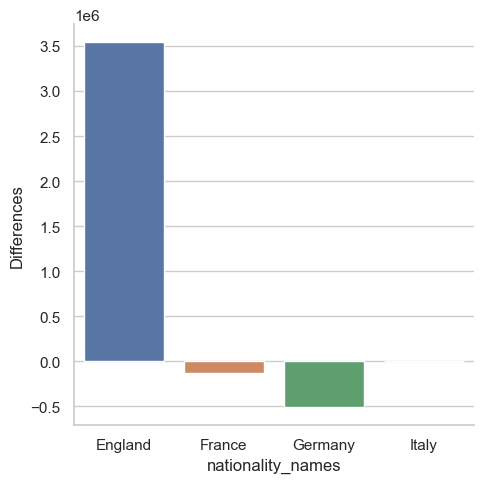

In [369]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds2_residuals, kind = "bar", x = "nationality_names", y = "Differences", legend_out = False)

In [ ]:
#plot, find all resids for each nation

In [391]:
group_test = bias_ds2["nationality_name"]

In [392]:
England_resids = (bias_ds2[group_test == "England"]["Actual"]) - (bias_ds2[group_test == "England"]["Predicted"])
France_resids = (bias_ds2[group_test == "France"]["Actual"]) - (bias_ds2[group_test == "France"]["Predicted"])
Germany_resids = (bias_ds2[group_test == "Germany"]["Actual"]) - (bias_ds2[group_test == "Germany"]["Predicted"])
Italy_resids = (bias_ds2[group_test == "Italy"]["Actual"]) - (bias_ds2[group_test == "Italy"]["Predicted"])

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

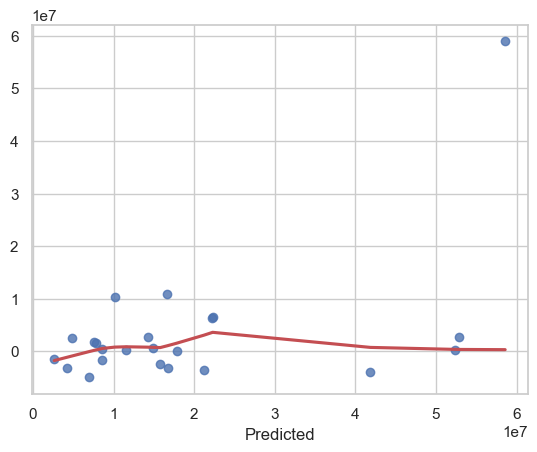

In [394]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "England"]["Predicted"], y = England_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

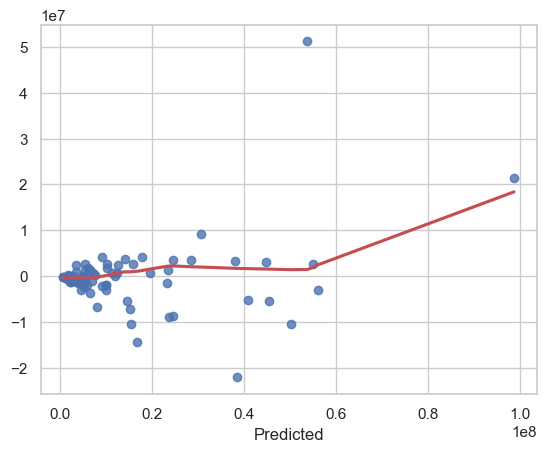

In [395]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "France"]["Predicted"], y = France_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

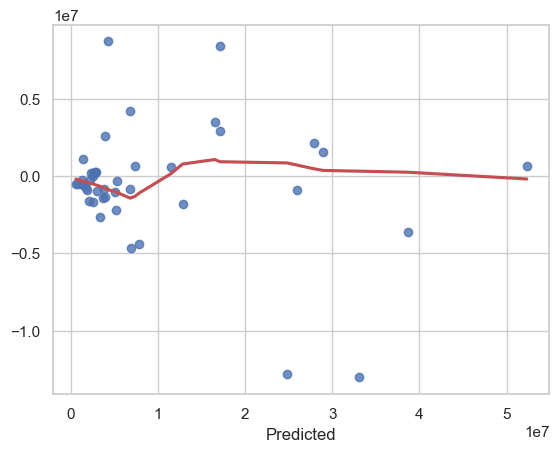

In [396]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "Germany"]["Predicted"], y = Germany_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

(0.0, 5.561192392894468, -1.7049968840877454, 2.6335733746858283)

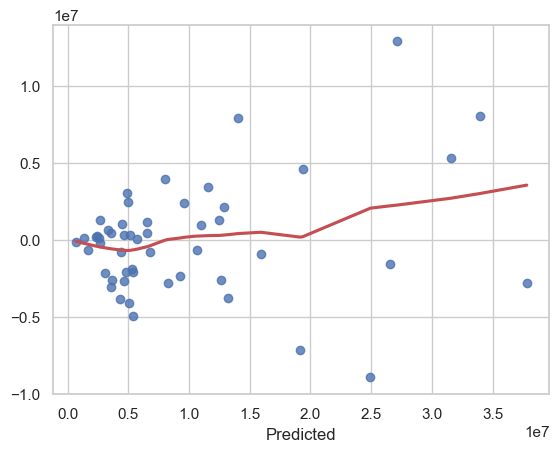

In [397]:
#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = bias_ds2[group_test == "Italy"]["Predicted"], y = Italy_resids, lowess=True, line_kws=dict(color="r"))
axarr[1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1].axis(xmin=0)

In [ ]:
#find threshold for good / bad predictions; # of good vs. number of bad predictions